In [1]:
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
from ClassificationModels.LSTM_T import LSTM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import os 
from tslearn.datasets import UCR_UEA_datasets

# Parameters

In [2]:
#dataset='GunPoint'f
dataset='BasicMotions'

# Load Data

In [3]:
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)

In [4]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))    

# Model Training

In [5]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
device='cpu'
hidden_size=10
rnn=0.1
model = LSTM(6, hidden_size ,n_pred_classes,rnndropout=rnn).to(device)
#fit(model,train_loader,test_loader)
if dataset in os.listdir('../../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../../ClassificationModels/models/{dataset}')
#torch.save(model.state_dict(), f'../../ClassificationModels/models/{dataset}/LSTM')
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/LSTM'))

model.eval()
test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)

sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'../../ClassificationModels/models/{dataset}/LSTM_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'../../ClassificationModels/models/{dataset}/LSTMclassification_report.csv', index = False)

Folder exists


# Explanation Algo

In [6]:
item=test_x[0].reshape(1,-1,6)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
y_target= model(_item).detach().numpy()
#y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

In [7]:
from TSInterpret.InterpretabilityModels.Saliency.SaliencyMethods_PTY import Saliency_PTY
int_mod=Saliency_PTY(model, train_x.shape[-1],train_x.shape[-2], method='FA', mode ='time')

2022-12-21 12:19:25.329412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 12:19:29.264029: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-21 12:19:29.264478: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-21 12:19:29.264535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [8]:
exp=int_mod.explain(np.array([test_x[0,:,:]]),labels =1 ,TSR = True)

time mode


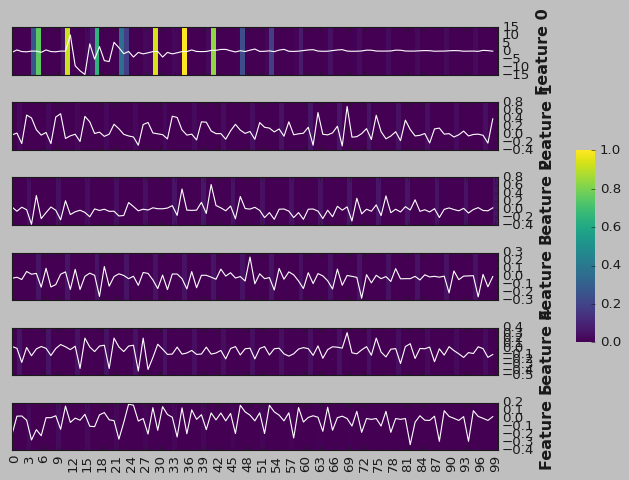

In [9]:
int_mod.plot(np.array([test_x[0,:,:]]),exp)

time mode


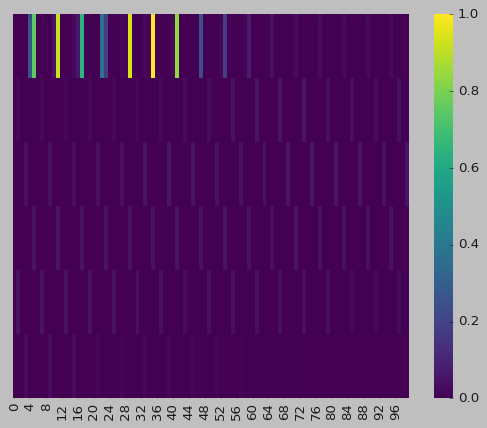

In [10]:
int_mod.plot(np.array([test_x[0,:,:]]),exp, heatmap = True)